# Gated Convolutional Neural Network (GCN) for Neutone Fx


This notebook is designed as an introductory "walk-through" the process of training and exporting a Neutone model that emulates an audio effect. The training is designed as a supervised learning process on a user-defined dataset of input and target (processed) audio file. The **Gated Convolutional Network (GCN)** learns to predict the difference between the dry and wet audio, approximating that function will permit to the processing of data (audio signals) that is not part of the dataset. Finally, the trained model is exported to a format that can be used in Neutone Fx Plugin.

The example provided aims to emulate a spring reverb, but the same process can be used to emulate other effects. The only difference would be the training data.

Author: [Francesco Papaleo](https://github.com/francescopapaleo) | Date: 2023-11-29

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francescopapaleo/neural-audio-spring-reverb/blob/main/notebooks/neutone_GCN_demo.ipynb)

In [2]:
#@title Install packages
print("Installing the neutone SDK and other necessary packages")
%pip install auraloss neutone_sdk torchinfo
print("Done!")

Installing the neutone SDK and other necessary packages
Done!


In [3]:
#@title Python packages imports

import IPython
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import auraloss
import shutil

from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torchinfo import summary
from typing import Dict, List, Optional, Tuple, Union
from IPython.display import Image
from tqdm.notebook import tqdm
from pathlib import Path
from ipywidgets import widgets

import neutone_sdk
from neutone_sdk import WaveformToWaveformBase, NeutoneParameter
from neutone_sdk.utils import save_neutone_model

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5

print(f'PyTorch version:{torch.__version__}')

PyTorch version:2.1.0+cu118


In [4]:
#@title Google Colab setup and drive mount

import locale
locale.getpreferredencoding = lambda: "UTF-8"   # to avoid the occasional encoding error in Colab

from google.colab import drive      # mount the drive
drive.mount('/drive')

from google.colab import files

#@markdown Set the folder where all the generated files will be saved:
home_folder = '/drive/MyDrive/neutone-gcn-demo' #@param
if not os.path.exists(home_folder):
    os.makedirs(home_folder)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


**Data structure**

Custom dataset for the dry-wet audio pairs. Those can be a subset of another dataset or user-generated. The folder structure should be as follows:
```
data_dir                # Main folder for the custom dataset
    ├── input           # Folder for the dry/input/x audio files
    │   ├── 001.wav
    │   ├── 002.wav
    │   ├── ...
    ├── target          # Folder for the wet/target/y audio files
    │   ├── 001.wav
    │   ├── 002.wav
    │   ├── ...
```

In [6]:
#@title Custom Dataset Class

class CustomAudioDataset(Dataset):
    """
    Custom dataset for the dry-wet audio pairs.
    Those can be a subset of another dataset or user-generated.

    The folder structure should be as follows:
    data_dir                # Main folder for the custom dataset
        ├── input           # Folder for the dry/input/x audio files
        │   ├── 001.wav
        │   ├── 002.wav
        │   ├── ...
        ├── target          # Folder for the wet/target/y audio files
        │   ├── 001.wav
        │   ├── 002.wav
        │   ├── ...
    """

    def __init__(
        self,
        data_dir,
        apply_contrast=True,
        apply_dc_offset_correction=True,
        apply_peak_normalize=True,
        sample_duration: int = 2,
        sample_rate: int = 48000,
    ):
        self.data_dir = Path(data_dir)
        self.input_dir = self.data_dir / "input"
        self.target_dir = self.data_dir / "target"

        self.apply_contrast = apply_contrast
        self.apply_dc_offset_correction = apply_dc_offset_correction
        self.apply_peak_normalize = apply_peak_normalize
        self.sample_length = int(sample_duration * sample_rate)

        self.dry_files = []
        self.wet_files = []

        # Divide files into dry and wet categories
        for file in self.input_dir.glob("*.wav"):
            self.dry_files.append(file)

        for file in self.target_dir.glob("*.wav"):
            self.wet_files.append(file)

        # Sort the file lists based on alphanumeric IDs
        self.dry_files.sort(key=lambda x: x.stem)
        self.wet_files.sort(key=lambda x: x.stem)

        assert len(self.dry_files) == len(
            self.wet_files
        ), "Dry and wet files must be paired with the same length."

    def __len__(self):
        return min(len(self.dry_files), len(self.wet_files))

    def load(self, audio_file):
        audio, sample_rate = torchaudio.load(audio_file, normalize=self.apply_peak_normalize)

        # Truncate audio to sample_length
        if audio.size(1) > self.sample_length:
            audio = audio[:, : self.sample_length]
        # print(audio.shape)
        return audio

    def apply_transforms(self, tensor):
        if self.apply_contrast:
            tensor = torchaudio.functional.contrast(tensor, 50)
        if self.apply_dc_offset_correction:
            tensor = tensor - torch.mean(tensor)
        if self.apply_peak_normalize:
            tensor /= torch.max(torch.abs(tensor))
        return tensor

    def __getitem__(self, idx):
        dry_path = self.dry_files[idx]
        wet_path = self.wet_files[idx]

        # Load audio files
        dry_tensor = self.load(dry_path)
        wet_tensor = self.load(wet_path)

        dry_tensor = self.apply_transforms(dry_tensor)
        wet_tensor = self.apply_transforms(wet_tensor)

        return dry_tensor, wet_tensor

    def collate_fn(batch):
        dry_tensors, wet_tensors = zip(*batch)
        return torch.cat(dry_tensors, dim=0), torch.cat(wet_tensors, dim=0)

    def split_dataset(self, batch_size, train_ratio=0.6, valid_ratio=0.2, test_ratio=0.2, num_workers=0, collate_fn=collate_fn):
            total_size = len(self)
            print(f"Total dataset size (input/target pairs): {total_size}")

            train_size = int(train_ratio * total_size)
            valid_size = int(valid_ratio * total_size)
            test_size = int(test_ratio * total_size)

            diff = total_size - (train_size + valid_size + test_size)
            train_size += diff

            train_data, valid_data, test_data = torch.utils.data.random_split(
                self, [train_size, valid_size, test_size]
            )

            train_loader = DataLoader(
                train_data,
                batch_size,
                num_workers=num_workers,
                shuffle=True,
                drop_last=True,
                # collate_fn=collate_fn,
                pin_memory=False,
            )
            valid_loader = DataLoader(
                valid_data,
                batch_size,
                num_workers=num_workers,
                shuffle=False,
                drop_last=True,
                # collate_fn=collate_fn,
                pin_memory=False,
            )
            test_loader = DataLoader(
                test_data,
                batch_size,
                num_workers=num_workers,
                shuffle=False,
                drop_last=True,
                # collate_fn=collate_fn,
                pin_memory=False,
            )

            return train_loader, valid_loader, test_loader

data_dir = "/drive/MyDrive/mir_datasets/customset/" #@param {type:"string"}
#@markdown This is the location where you put one folder with `input` audio files and another `target` with the processed ones.

batch_size = 20 #@param {type: "integer"}
#@markdown How many files will be processed simultaneously by the model during training: you can increase this number if the files are short.

sample_rate = 44100 # @param
#@markdown Sample rate of the audio files selected for the dataset

sample_duration = 2 #@param {type: "slider", min: 1, max: 20, step: 0.1}


custom_dataset = CustomAudioDataset(data_dir, sample_duration, sample_rate)
train_loader, valid_loader, test_loader = custom_dataset.split_dataset(batch_size=batch_size)

Total dataset size (input/target pairs): 624


In [7]:
#@title Define the GCN model class with causal convolution and FiLM layer for conditioning

class FiLM(nn.Module):
    def __init__(
        self,
        cond_dim: int,  # dim of conditioning input
        num_features: int,  # dim of the conv channel
        use_bn: bool = True,
    ) -> None:
        super().__init__()
        self.num_features = num_features
        self.use_bn = use_bn
        if self.use_bn:
            self.bn = nn.BatchNorm1d(num_features, affine=False)
        self.adaptor = nn.Linear(cond_dim, 2 * num_features)

    def forward(self, x: Tensor, cond: Tensor) -> Tensor:
        assert cond.ndim == 2
        cond = self.adaptor(cond)
        g, b = torch.chunk(cond, 2, dim=-1)
        g = g.unsqueeze(-1)
        b = b.unsqueeze(-1)

        if self.use_bn:
            x = self.bn(x)  # Apply batchnorm without affine
        x = (x * g) + b  # Then apply conditional affine

        return x

class Conv1dCausal(nn.Module):
    """Causal 1D convolutional layer
    ensures outputs depend only on current and past inputs.

    Parameters:
        in_channels (int): Number of channels in the input signal.
        out_channels (int): Number of channels produced by the convolution.
        kernel_size (int): Size of the convolving kernel.
        stride (int): Stride of the convolution.
        dilation (int, optional): Spacing between kernel elements.
        bias (bool, optional): If True, adds a learnable bias to the output.

    Returns:
        Tensor: The output of the causal 1D convolutional layer.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        dilation: int = 1,
        bias: bool = True,
    ) -> None:
        super().__init__()
        self.padding = (
            kernel_size - 1
        ) * dilation  # input_len == output_len when stride=1
        self.in_channels = in_channels
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            (kernel_size,),
            (stride,),
            padding=0,
            dilation=(dilation,),
            bias=bias,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = F.pad(x, (self.padding, 0))  # standard zero padding
        x = self.conv(x)
        return x

class GatedAF(nn.Module):
    """Gated activation function
    applies a tanh activation to one half of the input
    and a sigmoid activation to the other half, and then multiplies them element-wise.

    Returns:
        Tensor: The output of the gated activation function.
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        x_tanh, x_sigmoid = x.chunk(2, dim=1)  # Split the output into two halves

        x_tanh = torch.tanh(x_tanh)  # Apply tanh activation
        x_sigmoid = torch.sigmoid(x_sigmoid)  # Apply sigmoid activation

        # Element-wise multiplication of tanh and sigmoid activations
        x = x_tanh * x_sigmoid
        return x


class GCN1DBlock(nn.Module):
    """Single block of a Gated Convolutional Network (GCN) with conditional modulation.

    Parameters:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        kernel_size (int, optional): Size of the convolution kernel.
        dilation (int, optional): Dilation rate for dilated convolutions.
        stride (int, optional): Stride for the convolution.
        cond_dim (int, optional): Dimensionality of the conditional input for FiLM.
    """
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        kernel_size: int = 3,
        dilation: int = 1,
        stride: int = 1,
        cond_dim: int = 0,
        use_bias_in_conv: bool = False,
        use_bn: bool = False,
    ) -> None:
        super().__init__()

        self.conv = Conv1dCausal(
            in_channels=in_ch,
            out_channels=out_ch * 2,    # adapt for the Gated Activation Function
            kernel_size=kernel_size,
            stride=stride,
            dilation=dilation,
            bias=use_bias_in_conv,
        )

        self.film = None
        if cond_dim > 0:
            self.film = FiLM(cond_dim=cond_dim, num_features=out_ch * 2)

        self.gated_activation = GatedAF()

        self.res = nn.Conv1d(
            in_channels=in_ch, out_channels=out_ch, kernel_size=(1,), bias=False
        )

    def forward(self, x: Tensor, cond: Tensor) -> Tensor:
        x_in = x
        x = self.conv(x) # Apply causal convolution
        if cond is not None and self.film is not None: # Apply FiLM if conditional input is given
            x = self.film(x, cond)
        # Apply gated activation function
        x = self.gated_activation(x)
        # Apply residual convolution and add to output
        x_res = self.res(x_in)
        x = x + x_res
        return x


class GCN1D(nn.Module):
    """Gated Convolutional Network (GCN) model, often used in sequence modeling tasks.

    Parameters:
        in_ch (int, optional): Number of input channels.
        out_ch (int, optional): Number of output channels.
        n_blocks (int, optional): Number of GCN blocks.
        n_channels (int, optional): Number of channels in the GCN blocks.
        dilation_growth (int, optional): Growth rate for dilation in the GCN blocks.
        kernel_size (int, optional): Size of the convolution kernel.
        cond_dim (int, optional): Dimensionality of the conditional input for FiLM.

    Returns:
        Tensor: The output of the GCN model.
    """
    def __init__(
        self,
        in_ch: int = 1,
        out_ch: int = 1,
        n_blocks: int = 10,
        n_channels: int = 64,
        dil_growth: int = 4,
        kernel_size: int = 13,
        cond_dim: int = 0,
        use_act: bool = True,
        use_bias_in_conv: bool = False,
    ) -> None:
        super().__init__()
        self.kernel_size = kernel_size
        self.n_channels = n_channels
        self.dil_growth = dil_growth
        self.n_blocks = n_blocks
        self.cond_dim = cond_dim
        self.use_act = use_act
        self.use_bias_in_conv = use_bias_in_conv

        # Compute convolution channels and dilations
        self.channels = [n_channels] * n_blocks
        self.dilations = [dil_growth ** idx for idx in range(n_blocks)]

        # Blocks number is given by the number of elements in the channels list
        self.n_blocks = len(self.channels)
        assert len(self.dilations) == self.n_blocks

        # Create a list of strides
        self.strides = [1] * self.n_blocks

        # Create a list of GCN blocks
        self.blocks = nn.ModuleList()
        block_out_ch = None

        for idx, (curr_out_ch, dil, stride) in enumerate(
            zip(self.channels, self.dilations, self.strides)
        ):
            if idx == 0:
                block_in_ch = in_ch
            else:
                block_in_ch = block_out_ch
            block_out_ch = curr_out_ch

            self.blocks.append(
                GCN1DBlock(
                    block_in_ch,
                    block_out_ch,
                    self.kernel_size,
                    dilation=dil,
                    stride=stride,
                    cond_dim=self.cond_dim,
                    use_bias_in_conv=self.use_bias_in_conv,
                )
            )

        # Output layer
        self.out_net = nn.Conv1d(
            self.channels[-1], out_ch, kernel_size=(1,), stride=(1,), bias=False
        )

        # Activation function
        self.act = nn.Tanh()

    def forward(self, x: Tensor, cond: Tensor) -> Tensor:
        assert x.ndim == 3 # (batch_size, in_ch, samples)
        if cond is not None:
            assert cond.ndim == 2 # (batch_size, cond_dim)
        for block in self.blocks: # Apply GCN blocks
            x = block(x, cond)
        x = self.out_net(x) # Apply output layer

        if self.act is not None:
            x = self.act(x)  # Apply tanh activation function
        return x

    def calc_receptive_field(self) -> int:
        """Calculate the receptive field of the model.
        The receptive field is the number of input samples that affect the output of a block.

        The receptive field of the model is the sum of the receptive fields of all layers:
        RF = 1 + \sum_{i=1}^{n}(kernel\_size_i - 1) \cdot dilation_i

        i is the layer index, n is the number of layers.

        Returns:
            int: The receptive field of the model.
        """
        assert all(_ == 1 for _ in self.strides)  # TODO(cm): add support for dsTCN
        assert self.dilations[0] == 1  # TODO(cm): add support for >1 starting dilation
        rf = self.kernel_size
        for dil in self.dilations[1:]:
            rf = rf + ((self.kernel_size - 1) * dil)
        return rf

#@markdown These parameters establish the "sizes" of the neural network and determine its depth. As a rule of thumb: larger numbers will determine a bigger model, hence will demand more resources either for training as well as for real-time.
n_blocks: int = 4 # @param {type: "slider", min: 1.0, max: 10.0, step: 1}
#@markdown This is the depth of the neural network you want to train.
n_channels: int = 32 # @param {type: "slider", min: 1, max: 64, step: 1}
#@markdown Number of convolutional channels.
dil_growth: int = 16 # @param {type: "slider", min: 1, max: 32, step: 1}
#@markdown Rate at which the model "expands" the receptive field.
kernel_size: int = 13 # @param {type: "slider", min: 3, max: 41, step: 1}
#@markdown Size of the convolutional kernel.
cond_dim: int = 3 # @param {type: "slider", min: 0, max: 3, step: 1}
#@markdown Number of conditioning parameters that you want to have in the plugin.

In [8]:
#@title Instantiate the model and print the summary with `torchinfo`

model = GCN1D(
    n_blocks=n_blocks,
    n_channels=n_channels,
    dil_growth=dil_growth,
    kernel_size=kernel_size,
    cond_dim=cond_dim,
)

rf = model.calc_receptive_field()
print(f"Receptive field: {rf} samples or {(rf/sample_rate)*1e3:0.1f} ms")

dummy_x = torch.randn(1, 1, sample_rate)
dummy_cond = torch.randn(1, cond_dim)

summary(model, input_data=(dummy_x, dummy_cond))

Receptive field: 52429 samples or 1188.9 ms


Layer (type:depth-idx)                   Output Shape              Param #
GCN1D                                    [1, 1, 44100]             --
├─ModuleList: 1-1                        --                        --
│    └─GCN1DBlock: 2-1                   [1, 32, 44100]            --
│    │    └─Conv1dCausal: 3-1            [1, 64, 44100]            832
│    │    └─FiLM: 3-2                    [1, 64, 44100]            512
│    │    └─GatedAF: 3-3                 [1, 32, 44100]            --
│    │    └─Conv1d: 3-4                  [1, 32, 44100]            32
│    └─GCN1DBlock: 2-2                   [1, 32, 44100]            --
│    │    └─Conv1dCausal: 3-5            [1, 64, 44100]            26,624
│    │    └─FiLM: 3-6                    [1, 64, 44100]            512
│    │    └─GatedAF: 3-7                 [1, 32, 44100]            --
│    │    └─Conv1d: 3-8                  [1, 32, 44100]            1,024
│    └─GCN1DBlock: 2-3                   [1, 32, 44100]            --
│    

Selected device for training: cuda


Training Progress:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: Loss improved from  inf to 1.556432 -> Saving model
Epoch 1: Loss improved from 1.556432 to 1.247329 -> Saving model
Epoch 2: Loss improved from 1.247329 to 1.151277 -> Saving model
Epoch 3: Loss improved from 1.151277 to 1.132065 -> Saving model
Epoch 4: Loss improved from 1.132065 to 1.113989 -> Saving model
Epoch 5: Loss improved from 1.113989 to 1.099960 -> Saving model
Epoch 6: Loss improved from 1.099960 to 1.096442 -> Saving model
Epoch 7: Loss improved from 1.096442 to 1.083589 -> Saving model
Epoch 8: Loss improved from 1.083589 to 1.075444 -> Saving model
Epoch 10: Loss improved from 1.075444 to 1.074451 -> Saving model
Epoch 12: Loss improved from 1.074451 to 1.068356 -> Saving model
Epoch 13: Loss improved from 1.068356 to 1.067867 -> Saving model
Epoch 14: Loss improved from 1.067867 to 1.067202 -> Saving model
Epoch 16: Loss improved from 1.067202 to 1.059787 -> Saving model
Epoch 19: Loss improved from 1.059787 to 1.059536 -> Saving model
Epoch 23: Loss improved

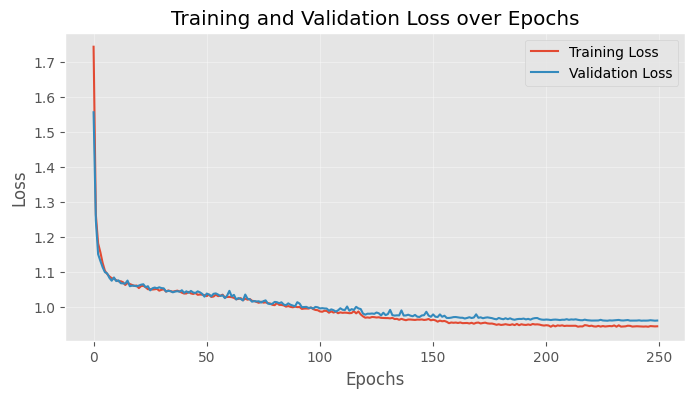

In [9]:
#@title Training loop

max_epochs = 250 #@param {type: "slider", min: 1, max: 250, step: 1}
#@markdown How many times the neural network is going to iterate over the entire data.
early_stop_patience = 50 #@param {type: "slider", min: 10, max: 50, step: 1}
#@markdown Sets a threshold after which the training is going to stop
model_name = "chorus_model" #@param {type: "string"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion1 = auraloss.freq.STFTLoss()
criterion2 = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=10, factor=0.5, verbose=True
)

print(f"Selected device for training: {device}")

min_valid_loss = float("inf")
current_epoch = 0

if cond_dim > 0:
    cond = torch.zeros((batch_size, cond_dim)).to(device)

train_losses = []
valid_losses = []

for epoch in tqdm(range(current_epoch, max_epochs), desc="Training Progress"):
    train_loss = 0.0

    model.train()
    for batch_idx, (dry, wet) in enumerate(train_loader):
        # print(f"\rEpoch {epoch} - Batch {batch_idx}/{len(train_loader)}", end="")
        # print(type(dry), type(wet))  # Add this line to inspect types
        # print(dry.shape, wet.shape)  # Add this line to inspect shapes
        input = dry.to(device)
        target = wet.to(device)
        model = model.to(device)

        pred = model(input, cond)

        loss1 = criterion1(pred, target)
        loss2 = criterion2(pred, target)
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        lr = optimizer.param_groups[0]["lr"]

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for step, (dry, wet) in enumerate(valid_loader):
            input = dry.to(device)  # Adjust here to remove the extra dimension
            target = wet.to(device)  # Adjust here to remove the extra dimension

            pred = model(input, cond)

            loss1 = criterion1(pred, target)
            loss2 = criterion2(pred, target)
            loss = loss1 + loss2

            valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

    scheduler.step(avg_valid_loss)

    # Save the model if it improved
    if avg_valid_loss < min_valid_loss:
        tqdm.write(
            f"Epoch {epoch}: Loss improved from {min_valid_loss:4f} to {avg_valid_loss:4f} -> Saving model"
        )
        min_valid_loss = avg_valid_loss
        patience_count = 0
        torch.save(
            {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            },
            f"{home_folder}/{model_name}.pt")
    else:
        patience_count += 1
        # if config['early_stop_patience'] is not None and patience_count >= config['early_stop_patience']:
        if patience_count == early_stop_patience:
            tqdm.write(
                f"Epoch {epoch}: Loss did not improve for {patience_count} epochs, stopping training"
            )
            break

    current_epoch += 1

    final_train_loss = float(avg_train_loss)
    final_valid_loss = float(avg_valid_loss)

    pred = torchaudio.functional.highpass_biquad(pred, sample_rate, 10)
    target = torchaudio.functional.highpass_biquad(target, sample_rate, 10)

    pred = pred.view(-1).unsqueeze(0).cpu()
    target = target.view(-1).unsqueeze(0).cpu()

    target /= torch.max(torch.abs(target))
    pred /= torch.max(torch.abs(pred))

    # Save audio files
    dest_folder = os.path.join(home_folder, "samples")
    os.makedirs(dest_folder, exist_ok=True)

    save_out = os.path.join(dest_folder, "train_pred.wav")
    torchaudio.save(save_out, pred, sample_rate=sample_rate)

    save_target = os.path.join(dest_folder, "train_target.wav")
    torchaudio.save(save_target, target, sample_rate=sample_rate)


# Plot the losses
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
#@title Evaluate the model

print("Evaluating model...")
# Define metrics
mae = torch.nn.L1Loss()
esr = auraloss.time.ESRLoss()
dc = auraloss.time.DCLoss()
mrstft = auraloss.freq.MultiResolutionSTFTLoss(
    fft_sizes=[1024, 2048, 8192],
    hop_sizes=[256, 512, 2048],
    win_lengths=[1024, 2048, 8192],
    scale="mel",
    n_bins=128,
    sample_rate=sample_rate,
    perceptual_weighting=True,
)

criterions = [mae, esr, dc, mrstft]
test_results = {"eval/mae": [], "eval/esr": [], "eval/dc": [], "eval/mrstft": []}

num_batches = len(test_loader)

model.eval()
with torch.no_grad():
    for step, (dry, wet) in enumerate(tqdm(test_loader, total=num_batches, desc="Processing batches")):
        global_step = step + 1

        input = dry.to(device)
        target = wet.to(device)

        pred = model(input, cond)

        # Compute metrics means for current batch
        for metric, name in zip(criterions, test_results.keys()):
            batch_score = metric(pred, target).item()
            test_results[name].append(batch_score)

        # Save audios from last batch
        if step == num_batches - 1:
            input = input.view(-1).unsqueeze(0).cpu()
            target = target.view(-1).unsqueeze(0).cpu()
            pred = pred.view(-1).unsqueeze(0).cpu()

            input /= torch.max(torch.abs(input))
            target /= torch.max(torch.abs(target))
            pred /= torch.max(torch.abs(pred))

            # Save audio files
            dest_folder = os.path.join(home_folder, "samples")
            os.makedirs(dest_folder, exist_ok=True)

            save_out = os.path.join(dest_folder, "eval_pred.wav")
            torchaudio.save(save_out, pred, sample_rate)

            save_target = os.path.join(dest_folder, "eval_target.wav")
            torchaudio.save(save_target, target, sample_rate)

mean_test_results = {k: sum(v) / len(v) for k, v in test_results.items()}

print("Average Evaluation Results:")
for metric_name, metric_value in mean_test_results.items():
    print(f"{metric_name}: {metric_value:.4f}")

Evaluating model...


Processing batches:   0%|          | 0/6 [00:00<?, ?it/s]

Average Evaluation Results:
eval/mae: 0.2279
eval/esr: 3.6401
eval/dc: 0.0000
eval/mrstft: 0.7041


In [11]:
#@title Listen and plot the results

# Plot Input Audio and Spectrogram
print("Input (dry)")
IPython.display.display(IPython.display.Audio(data=input[0].detach().cpu(), rate=sample_rate))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.specgram(input[0].detach().cpu().numpy(), Fs=sample_rate, scale='dB', cmap='inferno')
plt.title("Spectrogram")
plt.subplot(1, 2, 2)
plt.plot(input[0].detach().cpu().numpy())
plt.title("Waveform")
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

# Plot Target Audio and Spectrogram
print("Target")
IPython.display.display(IPython.display.Audio(data=target[0].detach().cpu(), rate=sample_rate))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.specgram(target[0].detach().cpu().numpy(), Fs=sample_rate, scale='dB', cmap='inferno')
plt.title("Spectrogram")
plt.subplot(1, 2, 2)
plt.plot(target[0].detach().cpu().numpy())
plt.title("Waveform")
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

# Plot Neural Network Output Audio and Spectrogram
print("Network Output")
IPython.display.display(IPython.display.Audio(data=pred[0].detach().cpu(), rate=sample_rate))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.specgram(pred[0].detach().cpu().numpy(), Fs=sample_rate, scale='dB', cmap='inferno')
plt.title("Spectrogram")
plt.subplot(1, 2, 2)
plt.plot(pred[0].detach().cpu().numpy())
plt.title("Waveform")
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [12]:
#@title Replace convolutional layers

class PaddingCached(nn.Module):
    """Cached padding for cached convolutions."""

    def __init__(self, n_ch: int, padding: int) -> None:
        super().__init__()
        self.n_ch = n_ch
        self.padding = padding
        self.register_buffer("pad_buf", torch.zeros((1, n_ch, padding)))

    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim == 3  # (batch_size, in_ch, samples)
        bs = x.size(0)
        if bs > self.pad_buf.size(0):  # Perform resizing once if batch size is not 1
            self.pad_buf = self.pad_buf.repeat(bs, 1, 1)
        x = torch.cat([self.pad_buf, x], dim=-1)  # concat input signal to the cache
        self.pad_buf = x[..., -self.padding :]  # discard old cache
        return x


class Conv1dCached(nn.Module):  # Conv1d with cache
    """Cached causal convolution for streaming."""

    def __init__(self, convcausal: Conv1dCausal) -> None:
        super().__init__()
        padding = convcausal.padding  # input_len == output_len when stride=1
        self.pad = PaddingCached(convcausal.in_channels, convcausal.padding)
        self.conv = convcausal.conv

    def forward(self, x: Tensor) -> Tensor:
        x = self.pad(x)  # get (cached input + current input)
        x = self.conv(x)
        return x

def replace_modules(module):
    for name, child in module.named_children():
        if isinstance(child, Conv1dCausal):
            # Create a new instance of Conv1dCached using the Conv1dCausal instance
            cached_conv = Conv1dCached(child)
            # Replace the Conv1dCausal instance with the Conv1dCached instance
            setattr(module, name, cached_conv)
        else:
            # If the child is not a Conv1dCausal instance, call the function recursively
            replace_modules(child)

replace_modules(model)
x_size = (1, 1, sample_rate)
cond_size = (1, cond_dim)
summary(model, input_size=[x_size, cond_size])

Layer (type:depth-idx)                   Output Shape              Param #
GCN1D                                    [1, 1, 44100]             --
├─ModuleList: 1-1                        --                        --
│    └─GCN1DBlock: 2-1                   [1, 32, 44100]            --
│    │    └─Conv1dCached: 3-1            [1, 64, 44100]            832
│    │    └─FiLM: 3-2                    [1, 64, 44100]            512
│    │    └─GatedAF: 3-3                 [1, 32, 44100]            --
│    │    └─Conv1d: 3-4                  [1, 32, 44100]            32
│    └─GCN1DBlock: 2-2                   [1, 32, 44100]            --
│    │    └─Conv1dCached: 3-5            [1, 64, 44100]            26,624
│    │    └─FiLM: 3-6                    [1, 64, 44100]            512
│    │    └─GatedAF: 3-7                 [1, 32, 44100]            --
│    │    └─Conv1d: 3-8                  [1, 32, 44100]            1,024
│    └─GCN1DBlock: 2-3                   [1, 32, 44100]            --
│    

In [13]:
#@title Wrap the model for the Neutone Fx plugin

class GCNModelWrapper(WaveformToWaveformBase):
    def get_model_name(self) -> str:
        return "gcn.demo"

    def get_model_authors(self) -> List[str]:
        return ["demo_user"]

    def get_model_short_description(self) -> str:
        return "Neural demo effect"

    def get_model_long_description(self) -> str:
        return "Neural demo effect through Gated Convolutional Neural Network with FiLM"

    def get_technical_description(self) -> str:
        return "Based on the idea proposed by Comunità et al."

    def get_tags(self) -> List[str]:
        return ["chorus"]

    def get_model_version(self) -> str:
        return "0.1.0"

    def is_experimental(self) -> bool:
        return True

    def get_technical_links(self) -> Dict[str, str]:
        return {
            "Paper": "http://arxiv.org/abs/2211.00497",
            "Code": "https://github.com/mcomunita/gcn-tfilm",
        }

    def get_citation(self) -> str:
        return "."

    def get_neutone_parameters(self) -> List[NeutoneParameter]:
        return [
            NeutoneParameter("depth", "Modulation Depth", 0.5),
            NeutoneParameter("P1", "Feature modulation 1", 0.0),
            NeutoneParameter("P2", "Feature modulation 2", 0.0),
            NeutoneParameter("P3", "Feature modulation 3", 0.0),
        ]

    @torch.jit.export
    def is_input_mono(self) -> bool:
        return True

    @torch.jit.export
    def is_output_mono(self) -> bool:
        return True

    @torch.jit.export
    def get_native_sample_rates(self) -> List[int]:
        return [sample_rate]

    @torch.jit.export
    def get_native_buffer_sizes(self) -> List[int]:
        return [2048]

    def do_forward_pass(self, x: Tensor, params: Dict[str, Tensor]) -> torch.Tensor:
        # conditioning for FiLM layer
        p1 = params["P1"]
        p2 = params["P2"]
        p3 = params["P3"]
        depth = params["depth"]
        cond = torch.stack([p1, p2, p3], dim=1) * depth
        cond = cond.expand(x.shape[0], 3)

        x = x.unsqueeze(1)
        x = self.model(x, cond)
        x = x.squeeze(1)
        return x


model = torch.jit.script(model.to("cpu"))

model_wrapper = GCNModelWrapper(model)

#@markdown Set the directory where you want to export the model:
neutone_dir = "neutone_export" #@param {type:"string"}
root_dir = os.path.join(home_folder, neutone_dir)

#@markdown Check this box to benchmark the Real Time Factor (RTF):
speed_benchmark = True #@param {type:"boolean"}
#@markdown If `1/RTF > 0` then the model is suitable for real-time application

# Call the export function
save_neutone_model(
    model=model_wrapper,
    root_dir=Path(root_dir),
    dump_samples=True,
    submission=True,

    max_n_samples=3,
    freeze=False,
    optimize=False,
    speed_benchmark=speed_benchmark,
)

INFO:neutone_sdk.utils:Converting model to torchscript...
INFO:neutone_sdk.utils:Extracting metadata...
INFO:neutone_sdk.utils:Running model on audio samples...
100%|██████████| 1000/1000 [00:05<00:00, 186.94it/s]
INFO:neutone_sdk.utils:Validating metadata...
INFO:neutone_sdk.utils:Saving model to /drive/MyDrive/neutone-gcn-demo/neutone_export/model.nm...
INFO:neutone_sdk.utils:Dumping samples to /drive/MyDrive/neutone-gcn-demo/neutone_export/samples...
INFO:neutone_sdk.utils:Loading saved model and metadata...
INFO:neutone_sdk.utils:Testing methods used by the VST...
INFO:neutone_sdk.utils:Running submission checks...
INFO:neutone_sdk.utils:Assert metadata was saved correctly...
INFO:neutone_sdk.utils:Assert loaded model output matches output of model before saving...
100%|██████████| 1566/1566 [00:07<00:00, 220.65it/s]
INFO:neutone_sdk.utils:Running benchmarks...
INFO:neutone_sdk.utils:Check out the README for additional information on how to run benchmarks with different parameters 

In [14]:
#@title Zip and download the wrapped model to use into Neutone plug-in

file_name = "GCN_neutone_export" #@param {type:"string"}
#@markdown Zip the folder containing the neutone wrapped model and download it.

button_download = widgets.Button(description="Download Model")
output_download = widgets.Output()

def on_download_clicked(b):
    with output_download:
        try:
            # Zip the directory
            shutil.make_archive(file_name, 'zip', root_dir)
            files.download(f"{file_name}.zip")
            print("Model download started...")
        except Exception as e:
            print(f"An error occurred: {e}")

button_download.on_click(on_download_clicked)

display(button_download, output_download)

Button(description='Download Model', style=ButtonStyle())

Output()